# GARCH Volatility Forecasting S&P500 and FTSE100

## Introduction

This project uses GARCH models to study and compare the volatility dynamics of three major equity indices: the S&P 500 and the FTSE 100.

In [51]:
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
pd.set_option('display.float_format', lambda x: f"{x:,.6f}")

## Data Collection

In [31]:
start = datetime(2000, 1, 1)
end = datetime.today()

In [33]:
spx = web.DataReader("^SPX", "stooq", start, end)
spx = spx.sort_index()
spx_close = spx["Close"].dropna()
# Log returns in % terms
spx_rets = 100 * np.log(spx_close / spx_close.shift(1))
spx_rets = spx_rets.dropna().rename("SP500_log_return_pct")

In [35]:
print("\nS&P 500 sample returns (%):")
print(spx_rets.head())
print("\nS&P 500 summary stats:")
print(spx_rets.describe(percentiles=[0.01,0.05,0.95,0.99]).round(4))


S&P 500 sample returns (%):
Date
2000-01-04   -3.909923
2000-01-05    0.192038
2000-01-06    0.095525
2000-01-07    2.672994
2000-01-10    1.112782
Name: SP500_log_return_pct, dtype: float64

S&P 500 summary stats:
count   6,470.000000
mean        0.023500
std         1.225300
min       -12.765200
1%         -3.492900
5%         -1.870100
50%         0.063300
95%         1.703200
99%         3.310000
max        10.957200
Name: SP500_log_return_pct, dtype: float64


In [36]:
ftse = web.DataReader("^UKX", "stooq", start, end)
ftse = ftse.sort_index()
ftse_close = ftse["Close"].dropna()
ftse_rets = 100 * np.log(ftse_close / ftse_close.shift(1))
ftse_rets = ftse_rets.dropna().rename("FTSE100_log_return_pct")

In [38]:
print("\nFTSE 100 sample returns (%):")
print(ftse_rets.head())
print("\nFTSE 100 summary stats:")
print(ftse_rets.describe(percentiles=[0.01,0.05,0.95,0.99]).round(4))


FTSE 100 sample returns (%):
Date
2000-01-05   -1.969492
2000-01-06   -1.366413
2000-01-07    0.889444
2000-01-10    1.569527
2000-01-11   -1.352999
Name: FTSE100_log_return_pct, dtype: float64

FTSE 100 summary stats:
count   6,500.000000
mean        0.005000
std         1.137100
min       -11.512400
1%         -3.394300
5%         -1.756600
50%         0.049900
95%         1.690200
99%         2.896900
max         9.384300
Name: FTSE100_log_return_pct, dtype: float64


In [41]:
# Combine into one dataframe
combined = pd.concat([spx_rets, ftse_rets], axis=1).dropna()

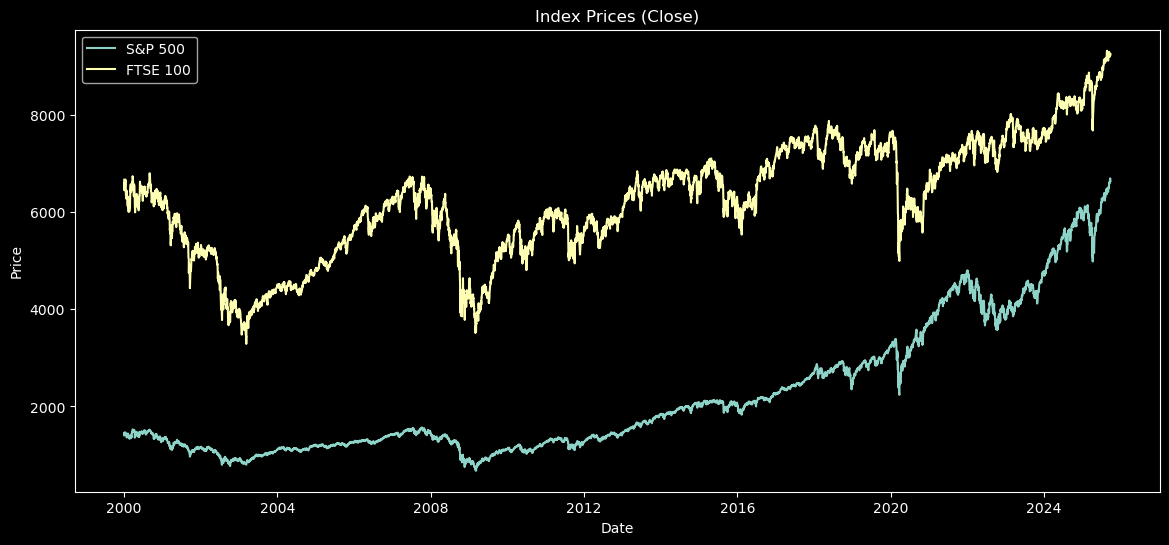

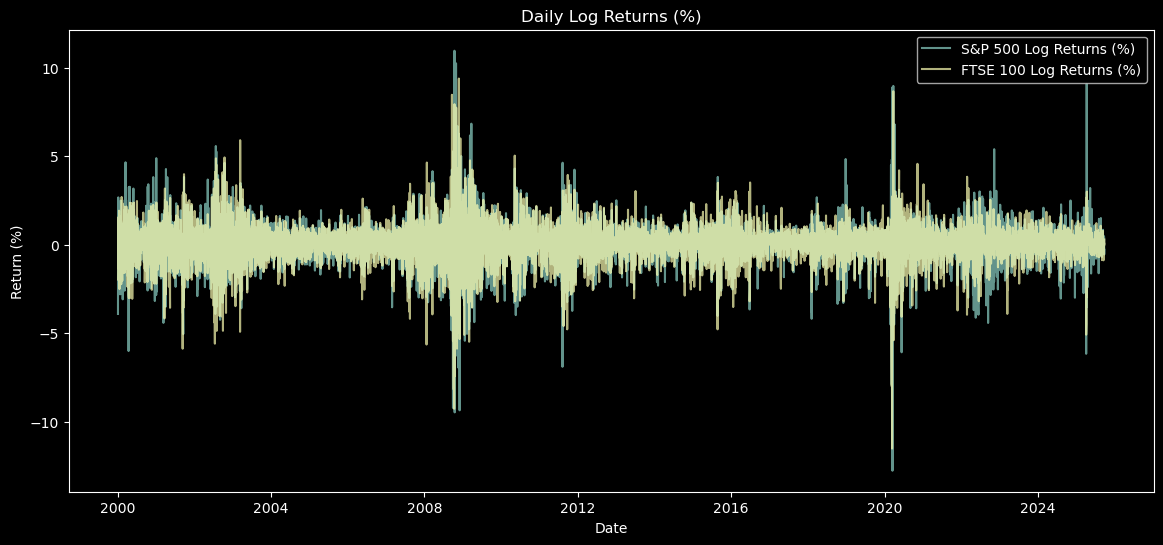

In [43]:
plt.figure(figsize=(14,6))
plt.plot(spx_close, label="S&P 500")
plt.plot(ftse_close, label="FTSE 100")
plt.title("Index Prices (Close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

plt.figure(figsize=(14,6))
plt.plot(spx_rets, label="S&P 500 Log Returns (%)", alpha=0.7)
plt.plot(ftse_rets, label="FTSE 100 Log Returns (%)", alpha=0.7)
plt.title("Daily Log Returns (%)")
plt.xlabel("Date")
plt.ylabel("Return (%)")
plt.legend()
plt.show()

## Testing for Volatility Clustering with the ARCH Test

To formally assess whether volatility clustering is present in daily log returns, we apply Engle’s ARCH LM test. The null hypothesis is that there are no ARCH effects (i.e., volatility is constant and past squared returns do not help explain current volatility).

In [45]:
# S&P 500 ARCH test
arch_test_spx = het_arch(spx_rets, nlags=10)
print("SPX ARCH Test (LM stat, LM pval, F stat, F pval):", arch_test_spx)

# FTSE 100 ARCH test
arch_test_ftse = het_arch(ftse_rets, nlags=10)
print("FTSE ARCH Test (LM stat, LM pval, F stat, F pval):", arch_test_ftse)

SPX ARCH Test (LM stat, LM pval, F stat, F pval): (1728.493064985944, 0.0, 235.5919991071775, 0.0)
FTSE ARCH Test (LM stat, LM pval, F stat, F pval): (1343.9206500581085, 1.2679179450165805e-282, 169.2018583394911, 3.097195e-317)


Both indices strongly reject the null hypothesis of no ARCH effects, with p-values essentially equal to zero. This provides very strong statistical evidence of volatility clustering in SPX and FTSE daily returns.

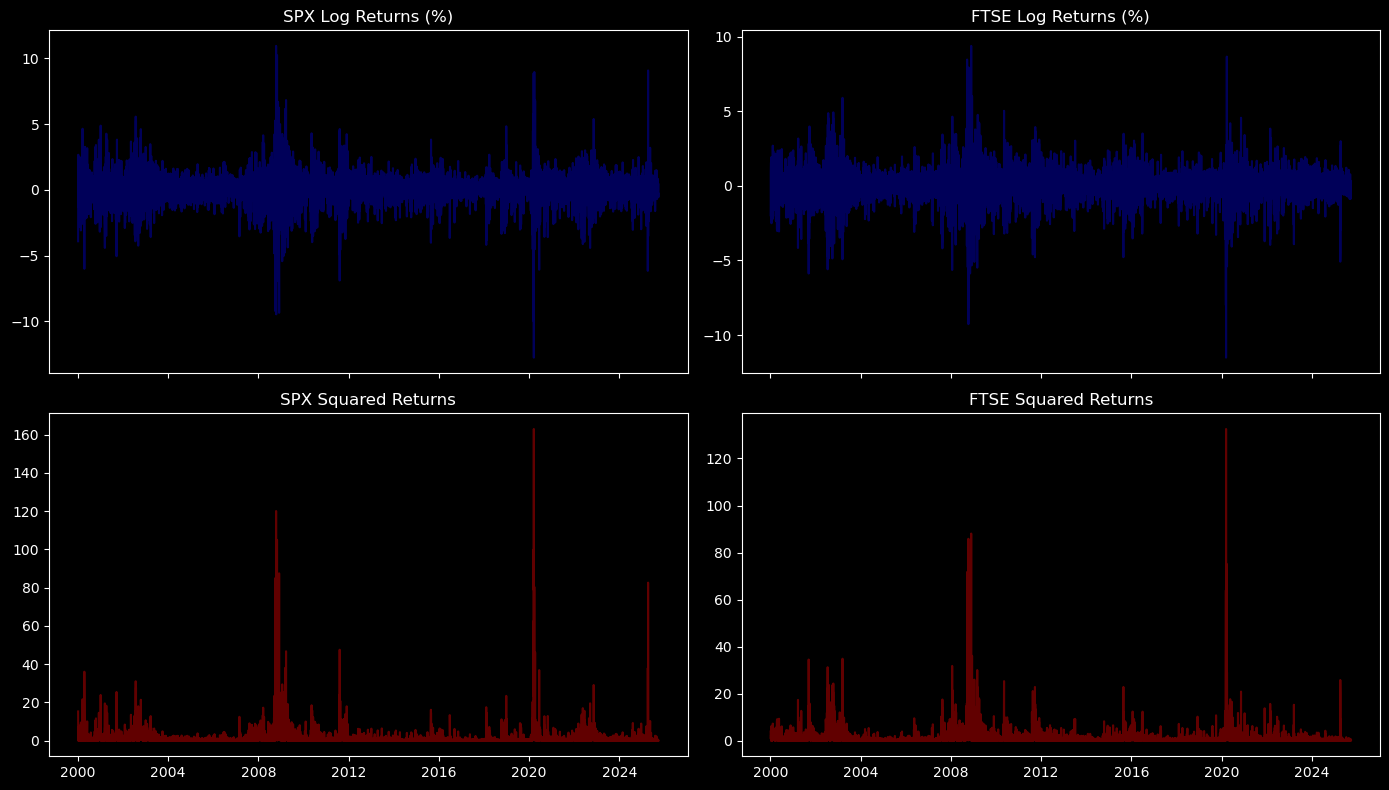

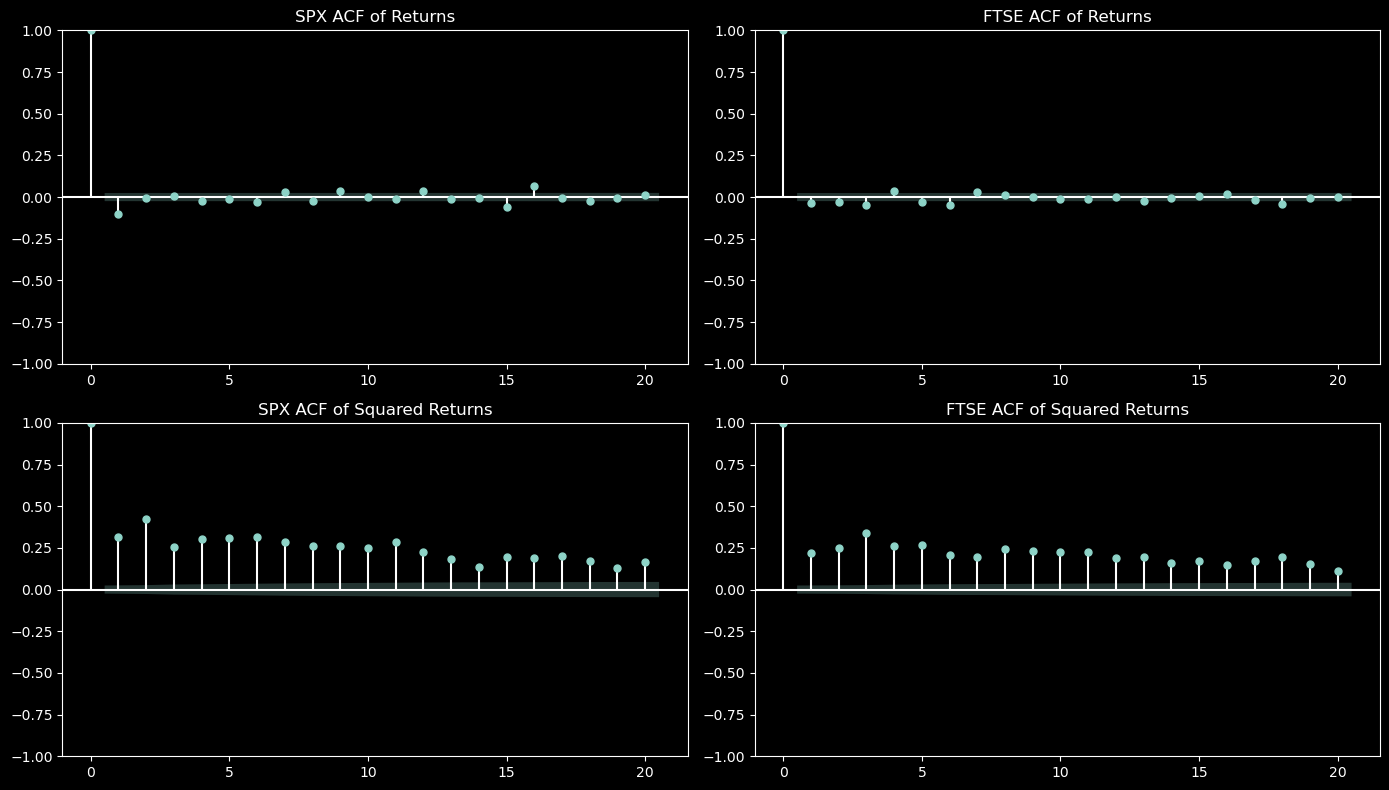

In [49]:
fig,axes=plt.subplots(2,2,figsize=(14,8),sharex=True)
axes[0,0].plot(spx_rets,color="navy",alpha=0.7);axes[0,0].set_title("SPX Log Returns (%)")
axes[1,0].plot(spx_rets**2,color="darkred",alpha=0.7);axes[1,0].set_title("SPX Squared Returns")
axes[0,1].plot(ftse_rets,color="navy",alpha=0.7);axes[0,1].set_title("FTSE Log Returns (%)")
axes[1,1].plot(ftse_rets**2,color="darkred",alpha=0.7);axes[1,1].set_title("FTSE Squared Returns")
plt.tight_layout();plt.show()

fig,axes=plt.subplots(2,2,figsize=(14,8))
plot_acf(spx_rets,lags=20,ax=axes[0,0],title="SPX ACF of Returns")
plot_acf(spx_rets**2,lags=20,ax=axes[1,0],title="SPX ACF of Squared Returns")
plot_acf(ftse_rets,lags=20,ax=axes[0,1],title="FTSE ACF of Returns")
plot_acf(ftse_rets**2,lags=20,ax=axes[1,1],title="FTSE ACF of Squared Returns")
plt.tight_layout();plt.show()

## GARCH modelling

In [52]:
# SPX: GARCH(1,1)-t
garch11_spx = arch_model(spx_rets, mean="Constant", vol="GARCH", p=1, q=1, dist="t")
res_garch_spx = garch11_spx.fit(update_freq=5, disp="off")
print("\n=== SPX GARCH(1,1)-t Results ===")
print(res_garch_spx.summary())

# SPX: EGARCH(1,1)-t (with leverage)
egarch11_spx = arch_model(spx_rets, mean="Constant", vol="EGARCH", p=1, o=1, q=1, dist="t")
res_egarch_spx = egarch11_spx.fit(update_freq=5, disp="off")
print("\n=== SPX EGARCH(1,1)-t Results ===")
print(res_egarch_spx.summary())

# FTSE: GARCH(1,1)-t
garch11_ftse = arch_model(ftse_rets, mean="Constant", vol="GARCH", p=1, q=1, dist="t")
res_garch_ftse = garch11_ftse.fit(update_freq=5, disp="off")
print("\n=== FTSE GARCH(1,1)-t Results ===")
print(res_garch_ftse.summary())

# FTSE: EGARCH(1,1)-t (with leverage)
egarch11_ftse = arch_model(ftse_rets, mean="Constant", vol="EGARCH", p=1, o=1, q=1, dist="t")
res_egarch_ftse = egarch11_ftse.fit(update_freq=5, disp="off")
print("\n=== FTSE EGARCH(1,1)-t Results ===")
print(res_egarch_ftse.summary())



=== SPX GARCH(1,1)-t Results ===
                        Constant Mean - GARCH Model Results                         
Dep. Variable:         SP500_log_return_pct   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -8766.84
Distribution:      Standardized Student's t   AIC:                           17543.7
Method:                  Maximum Likelihood   BIC:                           17577.6
                                              No. Observations:                 6470
Date:                      Thu, Sep 25 2025   Df Residuals:                     6469
Time:                              19:25:36   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
-----------------------------------------------

📈 SPX — GARCH(1,1)-t

The GARCH(1,1) estimates show μ ≈ 0.079, ω ≈ 0.015, α ≈ 0.124, and β ≈ 0.871. Because α + β ≈ 0.996, volatility is extremely persistent: shocks decay very slowly over time. The degrees-of-freedom parameter ν ≈ 6.3 indicates that the Student’s t distribution captures substantial fat tails relative to normality. The mean return μ is small but statistically significant.

📈 SPX — EGARCH(1,1)-t

The EGARCH(1,1) estimates show μ ≈ 0.048, α ≈ 0.140, β ≈ 0.979, and γ ≈ –0.167. Volatility is again highly persistent (α + β ≈ 1.119 on the log-variance scale), and the significant negative γ confirms the leverage effect: negative shocks increase volatility more than positive shocks of the same size. The Student’s t degrees of freedom ν ≈ 6.9 again indicate heavy tails. The mean return μ is smaller than in the GARCH model but still statistically significant.

📈 FTSE — GARCH(1,1)-t

The GARCH(1,1) estimates show μ ≈ 0.044, ω ≈ 0.021, α ≈ 0.121, and β ≈ 0.865. With α + β ≈ 0.986, volatility is highly persistent. The Student’s t ν ≈ 7.2 suggests that returns are fat-tailed compared with the normal distribution. The mean return μ is small but statistically significant.

📈 FTSE — EGARCH(1,1)-t

The EGARCH(1,1) estimates show μ ≈ 0.014, α ≈ 0.126, β ≈ 0.981, and γ ≈ –0.140. Persistence is very high (α + β ≈ 1.107 on the log-variance scale). The negative γ parameter again provides evidence of leverage effects: bad news drives larger increases in volatility than good news. The Student’s t ν ≈ 8.6 indicates moderately heavy tails. The mean return μ is positive but not statistically significant.

## Rolling GARCH Forecasting Approach

To evaluate the forecasting performance of the GARCH(1,1)-t model, we employ a rolling window estimation procedure. At each point in time, the model is re-estimated on the most recent 1500 trading days (~6 years of data) and used to generate a one-step-ahead forecast of conditional volatility. This procedure mimics how a practitioner would update risk forecasts in real time.

The realized volatility is proxied by the absolute daily return, and forecast errors are measured as the difference between forecasted volatility and realized volatility.

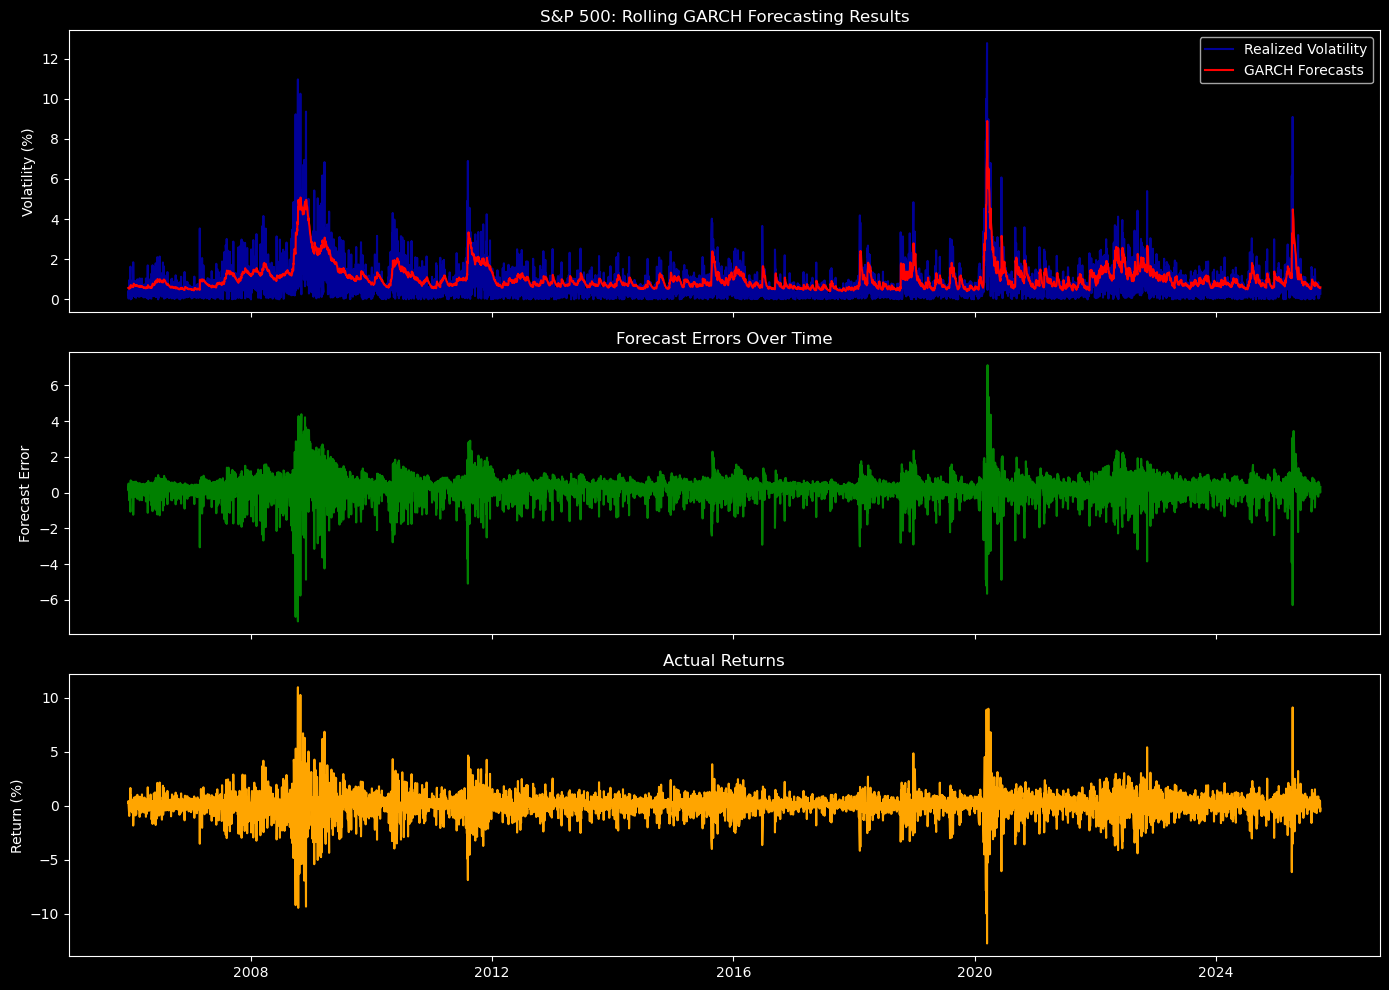

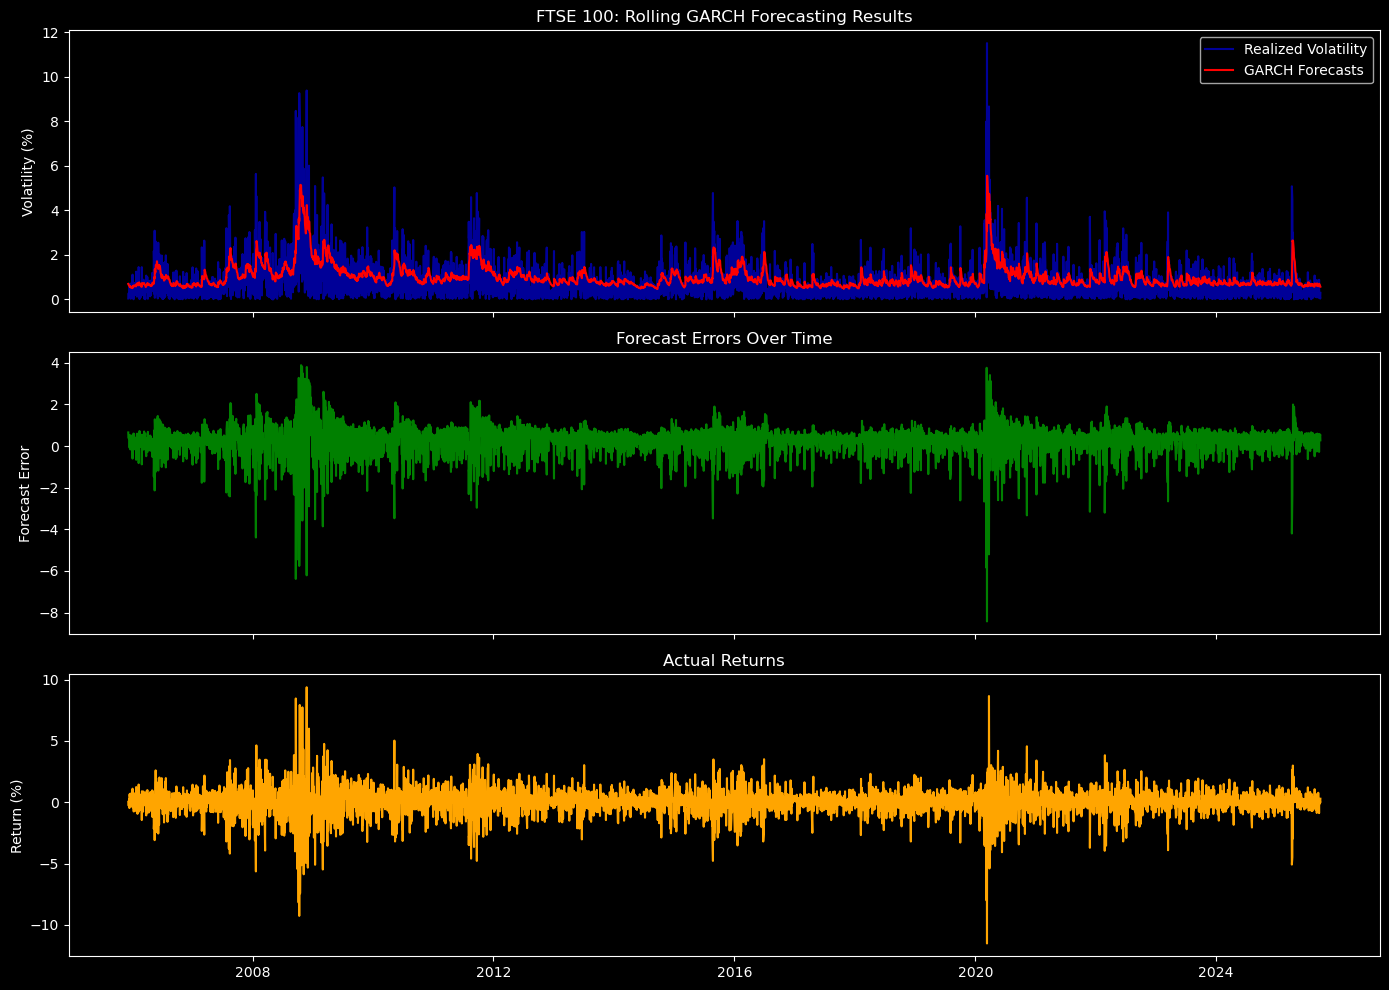

In [53]:
def rolling_garch_forecast(rets, window=1500, dist="t"):
    rets = rets.dropna()
    forecasts, realized, errors = [], [], []
    idxs = []
    for t in range(window, len(rets)):
        train = rets.iloc[t-window:t]
        model = arch_model(train, mean="Constant", vol="GARCH", p=1, q=1, dist=dist)
        res = model.fit(disp="off")
        fc = res.forecast(horizon=1, reindex=False)
        sigma2 = fc.variance.values[-1,0]
        forecasts.append(np.sqrt(sigma2))
        rv = abs(rets.iloc[t])  # realized volatility proxy
        realized.append(rv)
        errors.append(np.sqrt(sigma2) - rv)
        idxs.append(rets.index[t])
    return pd.Series(forecasts,index=idxs,name="ForecastVol"), \
           pd.Series(realized,index=idxs,name="RealizedVol"), \
           pd.Series(errors,index=idxs,name="Errors")

def plot_results(rets, forecast, realized, errors, label):
    fig, axes = plt.subplots(3,1,figsize=(14,10),sharex=True)

    axes[0].plot(realized, color="blue", alpha=0.6, label="Realized Volatility")
    axes[0].plot(forecast, color="red", label="GARCH Forecasts")
    axes[0].set_title(f"{label}: Rolling GARCH Forecasting Results")
    axes[0].set_ylabel("Volatility (%)"); axes[0].legend()

    axes[1].plot(errors, color="green")
    axes[1].set_title("Forecast Errors Over Time"); axes[1].set_ylabel("Forecast Error")

    axes[2].plot(rets.loc[forecast.index], color="orange")
    axes[2].set_title("Actual Returns"); axes[2].set_ylabel("Return (%)")

    plt.tight_layout(); plt.show()

# Run for SPX
f_spx, r_spx, e_spx = rolling_garch_forecast(spx_rets)
plot_results(spx_rets, f_spx, r_spx, e_spx, "S&P 500")

# Run for FTSE
f_ftse, r_ftse, e_ftse = rolling_garch_forecast(ftse_rets)
plot_results(ftse_rets, f_ftse, r_ftse, e_ftse, "FTSE 100")


## Results and Interpretation


*Volatility forecasts vs realized volatility (top panel):*

The red line (GARCH forecasts) tracks the blue line (realized volatility) reasonably well, capturing periods of elevated market turbulence such as volatility spikes during crises. However, the forecasts are smoother than realized volatility, reflecting the persistence built into the GARCH structure.


*Forecast errors over time (middle panel):*

Errors are centered around zero but show clusters of large deviations, especially during crisis periods. This reflects the model’s tendency to underpredict sudden volatility jumps.


*Actual returns (bottom panel):*

Volatility spikes coincide with large positive or negative returns, consistent with the clustering phenomenon observed earlier.



## Key Takeaways

**Persistence:**
The rolling GARCH forecasts show strong persistence, adapting gradually to new shocks.

**Reactivity:**
While the model adjusts after volatility spikes, it tends to lag behind sudden jumps.

**Practical use:**
Despite smoothing, GARCH forecasts provide valuable forward-looking measures of volatility that align with realized patterns, making them useful for risk management and VaR applications.